In [1]:
import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE



## Load Analytical Base Table

In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,30.5,33.6,0.627000,50.0,1
1,1.0,85.0,66.0,29.0,30.5,26.6,0.351000,31.0,0
2,8.0,183.0,64.0,23.0,30.5,23.3,0.672000,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167000,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,0.471876,33.0,1


### Separate dataframe into separate object

In [3]:
X = abt.drop(["class"], axis=1)

y = abt["class"]

# display shapes of X and y
print(X.shape, y.shape)

(768, 8) (768,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

[]

In [6]:
# distribution of Diabetics
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Diabetes':col1,'Diabetes %':col2.round(2)})

,Target,Diabetes,Diabetes %
0,0,500,65.1
1,1,268,34.9


## Create a Train Test Split

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

537 231 537 231


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 491 to 265
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    537 non-null    float64
 1   plas    537 non-null    float64
 2   pres    537 non-null    float64
 3   skin    537 non-null    float64
 4   test    537 non-null    float64
 5   mass    537 non-null    float64
 6   pedi    537 non-null    float64
 7   age     537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


## Pre-processing Pipeline

### Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder

Create lists of indexes from the list of column names

Need to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 2, 3, 4, 5, 6, 7]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)  

[]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [])])

## Build Model Pipeline with SMOTE

* We are going to use the Pipeline from the imblearn package in place of scikit-learn Pipeline.

* It takes care automatically to re-sample when called fit() on the pipeline, and does not re-sample test data (when called transform() or predict()).

In [12]:
# Import XGBoost
!pip install xgboost
import xgboost as xgb

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  xgb.XGBClassifier(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [])])),
                ('smote', SMOTE(random_state=10)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               earl...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [13]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [14]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {'xgbclassifier__gamma': [0.5, 0.8, 1],
              'xgbclassifier__max_depth': [3, 4, 5, 6],
              'xgbclassifier__n_estimators': [50, 100, 200]
        }
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='f1_macro')


In [15]:
# Train the model with GridSearch
grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6,
                                                                          7]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=Non...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=10, ...))]),
             n_jobs=4,
             param_grid={'xgbclassifier__gamma': [0.5, 0.8, 1],
                         'xgbclassifier__max_depth': [3, 4, 5, 6],
                         'xgbclassifier__n_estimators': [50, 100, 200]},
             scoring='f1_macro', verbose=3)

In [16]:
print(grid.best_params_)

{'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 50}


In [17]:
 # List the best score
print(grid.best_score_)

0.728006353754781


In [18]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.9249243348837912
Testing Data Score: 0.7287414965986394


In [19]:
# Make predictions with the hypertuned model
pred = grid.predict(X_test)
pred

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0])

In [20]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, pred)
print(cm)

[[118  26]
 [ 32  55]]


In [21]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.82 0.18]
 [0.37 0.63]]


In [22]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       144
           1       0.68      0.63      0.65        87

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231



In [23]:
print(f"Predicted classes: \t{list(pred[:10])}")
print(f"Actual Labels: \t\t{list(y_test[:10])}")

Predicted classes: 	[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Actual Labels: 		[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_10660\4047844520.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: \t\t{list(y_test[:10])}")


## Save the Model

In [24]:
import joblib

# We are saving our grid model
filename = '../models/challa_XGBoost_model.sav'
joblib.dump(grid, filename)

['../models/challa_XGBoost_model.sav']

## Loading the Model

In [25]:
# load the model
xgb_model = joblib.load(filename)
print(xgb_model.score(X_test, y_test))

0.7287414965986394


### Predict class for new data

In [26]:
# Let's use the first X_test record as new data
X_test[:1]

,preg,plas,pres,skin,test,mass,pedi,age
568,4.0,154.0,72.0,29.0,126.0,31.3,0.338,37.0


In [27]:
pred_new = xgb_model.predict(X_test[:1])

In [28]:
print(f"Predicted classes: \t{pred_new}")
print(f"Actual Labels: \t\t{list(y_test[:1])}")

Predicted classes: 	[1]
Actual Labels: 		[0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_10660\2156583341.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: \t\t{list(y_test[:1])}")


#### Original dataframe to numpy array

In [29]:
X_test[:1].to_numpy()

array([[  4.   , 154.   ,  72.   ,  29.   , 126.   ,  31.3  ,   0.338,
         37.   ]])

In [30]:
pred_new1 = xgb_model.predict(X_test[:1].to_numpy())
pred_new1

c:\Users\pavanksu2009\.virtualenvs\Diabetes-Classification-Ri9St7y4\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([1])

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [32]:
model_performance_classification_sklearn(grid, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.931099,0.955801,0.856436,0.903394


In [33]:
model_performance_classification_sklearn(grid, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.748918,0.632184,0.679012,0.654762


In [34]:
df1 = pd.DataFrame(model_performance_classification_sklearn(grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.748918
1,Recall,0.632184
2,Precision,0.679012
3,F1,0.654762


In [35]:
df2 = pd.DataFrame(model_performance_classification_sklearn(grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.931099
1,Recall,0.955801
2,Precision,0.856436
3,F1,0.903394


In [36]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.931099,0.748918
1,Recall,0.955801,0.632184
2,Precision,0.856436,0.679012
3,F1,0.903394,0.654762


In [37]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

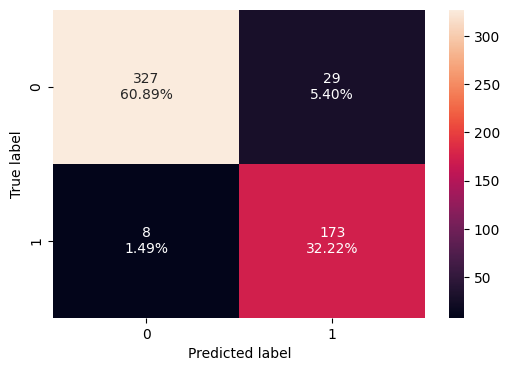

In [38]:
confusion_matrix_sklearn(grid, X_train, y_train)

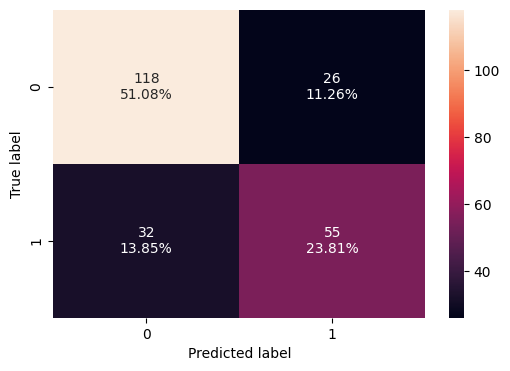

In [39]:
confusion_matrix_sklearn(grid, X_test, y_test)